## Part2 - Logistic Regression

In [14]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#avoid some warnings
np.seterr(all='ignore')

#data directory
path = './credit/'

#parameters to try
params = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])

In [2]:
#helper functions
def rescale(M, a=0., b=1.):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [12]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_err = np.empty((5,5))
    ts_err = np.empty((5,5))
    i = 0 #index of fold
    
    for tr_index,ts_index in kf:
        j = 0 #index of parameter
        for param in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, param)
            tr_err[i,j] = error_rate(X_train, y_train, beta)
            ts_err[i,j] = error_rate(X_test, y_test, beta)
            j += 1
        i += 1
        
    #arrays with mean costs for each alpha
    ts_mean = np.mean(ts_err, axis=0)
    return params[np.argmin(ts_mean)], tr_err, ts_err

"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,params):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(params[i]==winners)

    labels = ['alp1', 'alp2', 'alp3', 'alp4', 'alp5']
    pos = np.arange(len(labels))
    width = 1.0 
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.bar(pos, freqs, width, color='r')
    plt.title('Best alpha for each dataset')
    plt.show()

def solve_logistic(algorithm, params, data_func=None):
    winners = list()

    for i in xrange(20):
        #Loading dataset
        tr_file = path+'credit-tr-{0}.npy'.format(i)
        ts_file = path+'credit-ts-{0}.npy'.format(i)
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        #Adding column of 1's
        m,n = X_tr.shape
        X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)

        if data_func is not None:
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_ts = ts_data[:,:-1]
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        #Adding column of 1's
        m,n = X_ts.shape
        X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)

        alpha,tr_err,ts_err = cross_alpha(X_tr, y_tr, algorithm, params)
        winners.append(alpha)
        beta,it = algorithm(X_tr, y_tr, alpha)
        print "###########################################################"
        print "Dataset: {0}".format(i)
        print 'Best alpha: {0}'.format(alpha)
        fig = plt.figure()
        fig.set_figheight(7)
        fig.set_figwidth(13)
        fig.add_subplot(121)
        plt.boxplot(tr_err, showmeans=True, meanline=True)
        fig.add_subplot(122)
        plt.boxplot(ts_err, showmeans=True, meanline=True)
        plt.show()
        print 'Training error rate: {0}'.format(error_rate(X_tr,y_tr,beta))
        print 'Testing error rate: {0}'.format(error_rate(X_ts,y_ts,beta))
        print 'N° iterations: {0}'.format(it)
        print 'Beta: {0}'.format(beta)
        print "###########################################################"
        print '\n'
    make_hist(winners,params)
    

### Mean functions

In [4]:
#Sigmoid function
def sigmoid(z):
    return 1./(1.+np.exp(-z))

#Overall cost function for logistic regression (log likelihood function)
def l(X, y, beta):
    tmp = np.dot(X,beta)
    return (y*tmp - np.log(1.+np.exp(tmp))).sum()

#Error rate for logistic regression
def error_rate(X, y, beta):
    h = np.round(sigmoid(np.dot(X,beta)))
    h = h.astype(int)
    y = y.astype(int)
    m, = h.shape
    return np.logical_xor(h,y).sum()/np.float(m)

#Stochastic gradient ascent for logistic regression
def gd_stochastic(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in xrange(max_iter):
        l0 = l1
        for m in xrange(M):
            beta += alpha*(y[m]-sigmoid(np.dot(X[m],beta)))*X[m]
        #little trick
        #beta /= np.linalg.norm(beta)
        l1 = l(X,y,beta)
        if np.abs(l1-l0)/np.abs(l0) < eps: break
    return (beta,i+1)

#Newton-Raphson method for logistic regression
def nr_logistic(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in xrange(max_iter):
        l0 = l1
        h = sigmoid(np.dot(X,beta))
        W = np.diag(h*(1.-h))
        Hess = -1.*np.dot(X.T, np.dot(W, X))
        Dl = np.dot(X.T, y-h)
        #when it converges, Hess became singular
        try:
            beta -= alpha*np.linalg.solve(Hess, Dl)
        except np.linalg.LinAlgError:
            break
        #little trick
        #beta /= np.linalg.norm(beta)
        l1 = l(X, y, beta)
        if np.abs(l1-l0)/np.abs(l0) < eps: break
    return (beta,i+1)

In [5]:
#working array
wa = np.load(path+'credit-tr-3.npy')
#X = wa[:,:-1]
X = rescale(wa[:,:-1], 0., 1.)
#X = normalize(wa[:,:-1])
m,n = X.shape
X = np.concatenate((np.ones((m,1)),X),axis=1)
y = np.ascontiguousarray(wa[:,-1])

In [15]:
beta1,it = nr_logistic(X, y, 0.1)
print 'Beta:', beta1
print 'N° Iter:', it
print 'Error rate:', error_rate(X,y,beta1)

Beta: [  167.9171735    141.40890749 -1444.99053102  -224.8839149   3009.64375104
  -911.041382     118.90058578]
N° Iter: 432
Error rate: 0.0


In [19]:
beta2,it = gd_stochastic(X, y, 1e-1)
print 'Beta:', beta2
print 'N° iter:', it
print 'Error rate:', error_rate(X,y,beta2)

Beta: [   2.6544254     9.37065828  -67.56400651   -7.24590762  152.87002437
  -46.15487783    9.90481993]
N° iter: 73445
Error rate: 0.0


## 1)

In [24]:
params1 = np.array([0.2,0.4,0.6,0.8,1.0])
params2 = np.linspace(1e-2, 1e-1, 5, endpoint=True)

[ 0.01    0.0325  0.055   0.0775  0.1   ]


###########################################################
Dataset: 0
Best alpha: 0.2


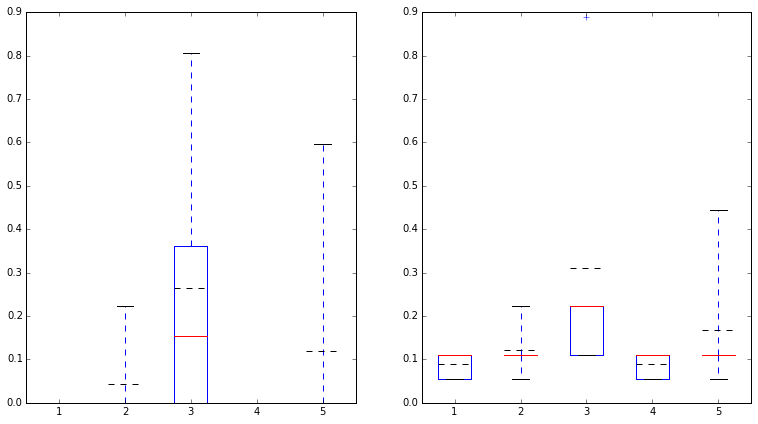

Training error rate: 0.0666666666667
Testing error rate: 0.166666666667
N° iterations: 249
Beta: [ -5.61686799e+14   2.39929714e+13   5.85243566e+10   1.42000949e+11
   2.02935143e+14  -6.69503317e+14  -8.82350101e+11]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.6


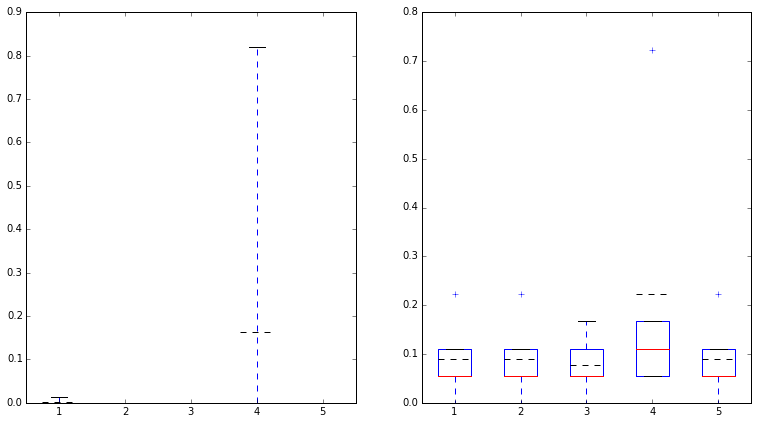

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 102
Beta: [ 3628.56591462   -12.8972489   -106.51142252    -3.997593    1059.08453674
 -2603.0981282      7.17945541]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.8


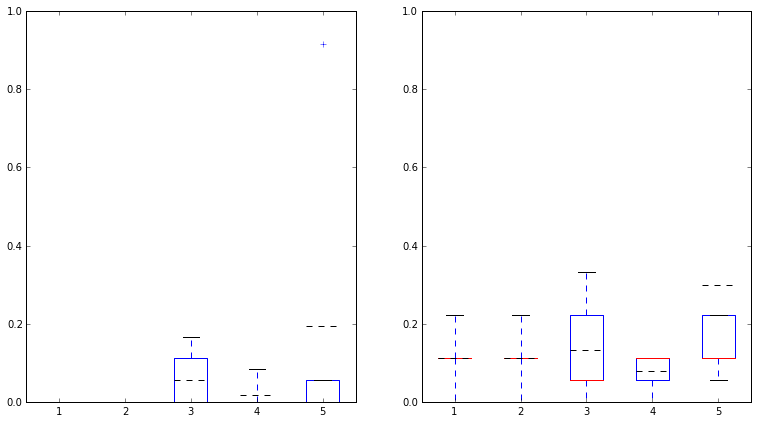

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 70
Beta: [ 1425.7448593     -4.65557339   -31.66267633    -2.17206746   318.34232103
  -933.77767451   -11.7145876 ]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.2


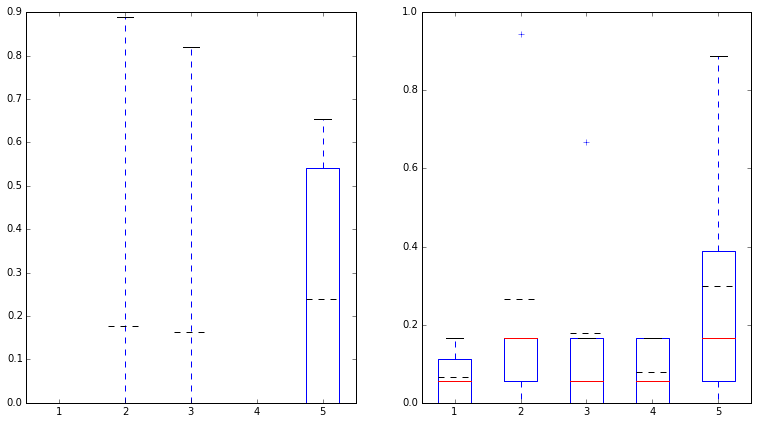

Training error rate: 0.933333333333
Testing error rate: 0.866666666667
N° iterations: 206
Beta: [  1.51803201e+31  -3.87492336e+29   3.56754865e+29  -3.84467731e+28
  -1.12037019e+31   2.55810000e+31  -6.76080320e+29]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.8


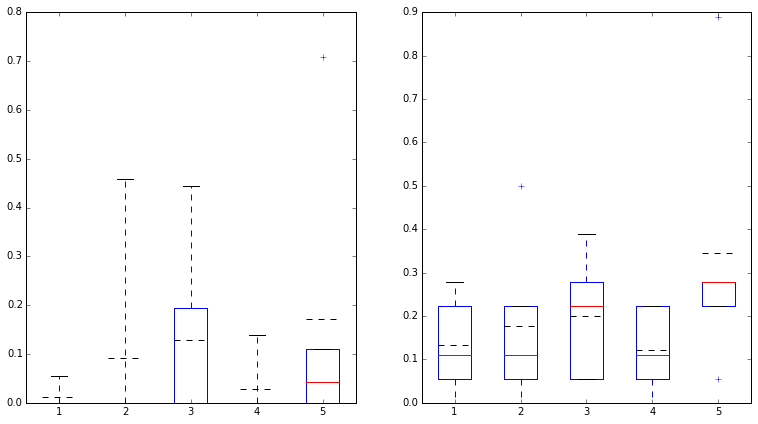

Training error rate: 0.1
Testing error rate: 0.1
N° iterations: 54
Beta: [  1.25812944e+17   6.49265288e+14  -3.48112084e+15  -2.07945402e+14
   1.12680053e+29  -3.38040160e+29  -1.64381791e+15]
###########################################################


###########################################################
Dataset: 5
Best alpha: 1.0


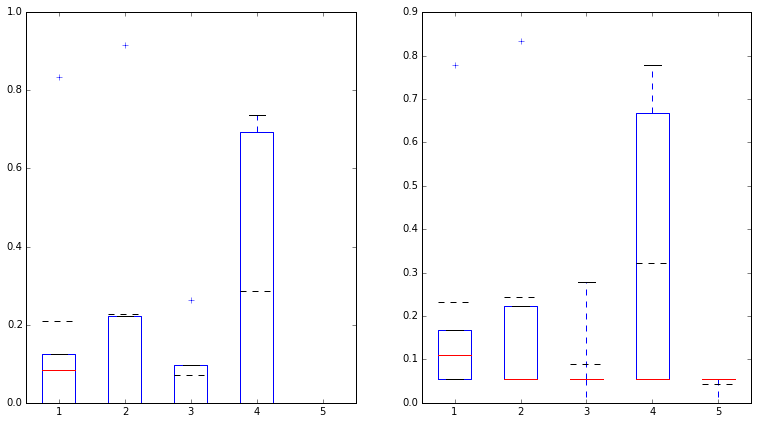

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 43
Beta: [ 10774.34397319     44.15473845   -352.6763011     -14.34873537
   3464.32383721  -8777.08080735    -18.39428108]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.6


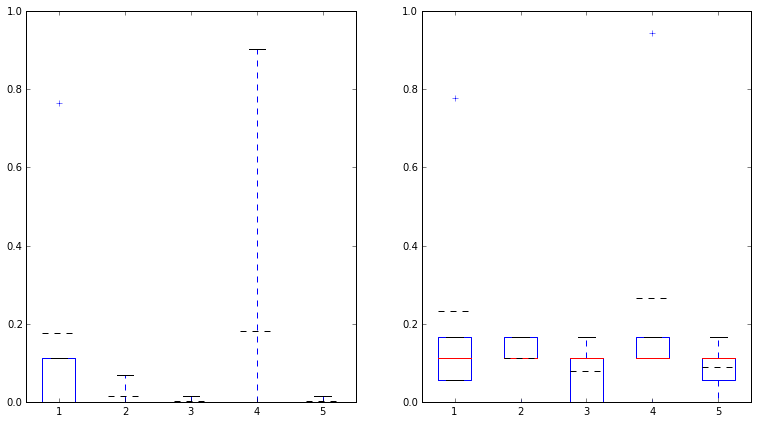

Training error rate: 0.9
Testing error rate: 0.933333333333
N° iterations: 127
Beta: [ -1.50129807e+44  -1.72147109e+43   1.69180783e+43   9.49992982e+41
  -1.23229598e+44   3.29928759e+44   1.43288386e+41]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.6


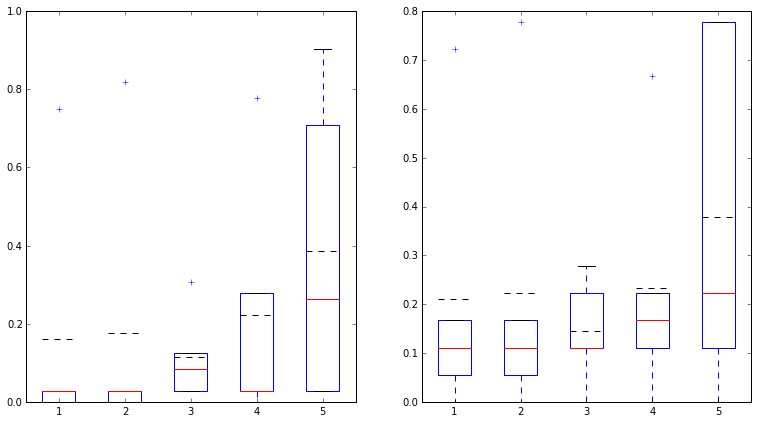

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 24
Beta: [  1.35518586e+02   8.89554071e-01  -4.87346080e+00  -1.93987297e-01
   5.49285335e+01  -1.39876231e+02  -6.42806241e-02]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.8


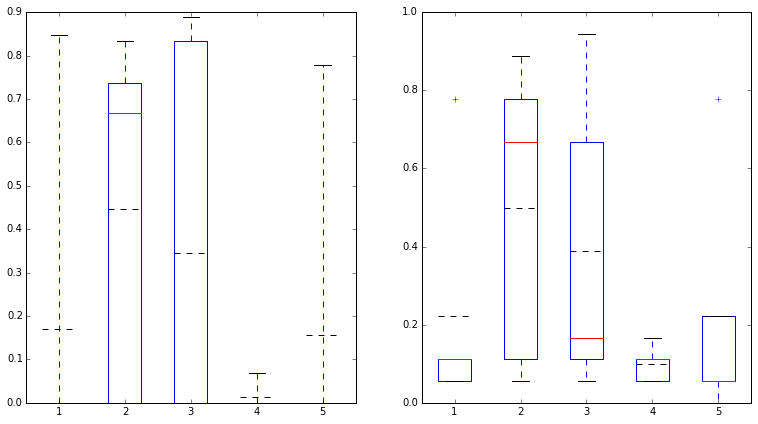

Training error rate: 0.911111111111
Testing error rate: 0.966666666667
N° iterations: 53
Beta: [ -3.29155984e+17  -3.35775582e+15   1.27801860e+16   5.32172065e+14
  -7.12492216e+16   1.60064667e+17  -4.19790392e+14]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.4


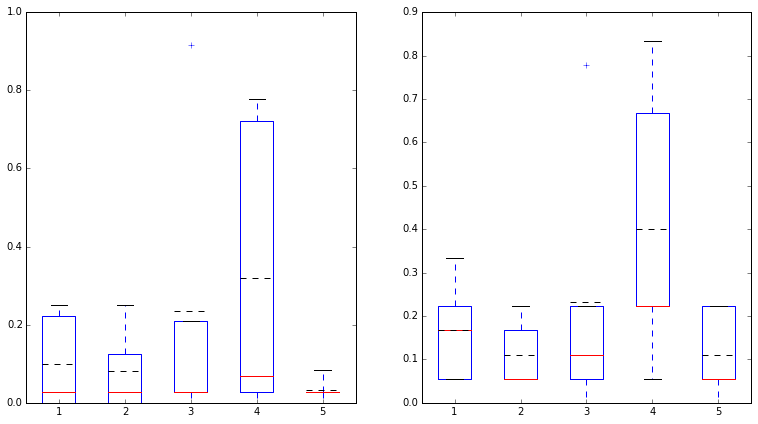

Training error rate: 0.111111111111
Testing error rate: 0.0333333333333
N° iterations: 103
Beta: [  5.28745462e+05   2.61341312e+03  -1.80867822e+04  -7.55163141e+02
   2.00162405e+15  -6.00487215e+15  -1.32118060e+03]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.8


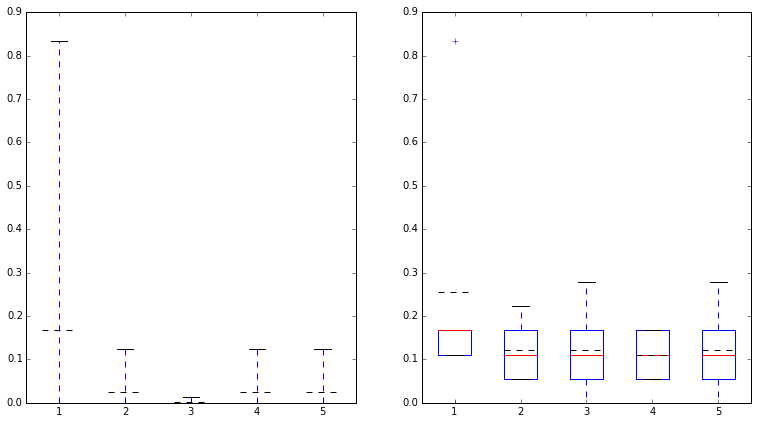

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 68
Beta: [ 2747.03974173    13.05887818   -81.97948154    -4.17579173   827.86296576
 -1942.09126768   -26.18776462]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.8


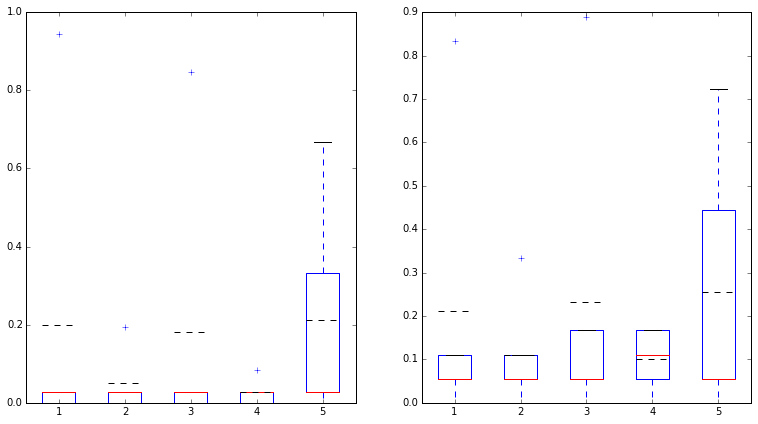

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 19
Beta: [ 340.07132347    1.74301713  -11.31534706   -0.47126475  119.17612049
 -305.86814113   -0.74734834]
###########################################################


###########################################################
Dataset: 12
Best alpha: 1.0


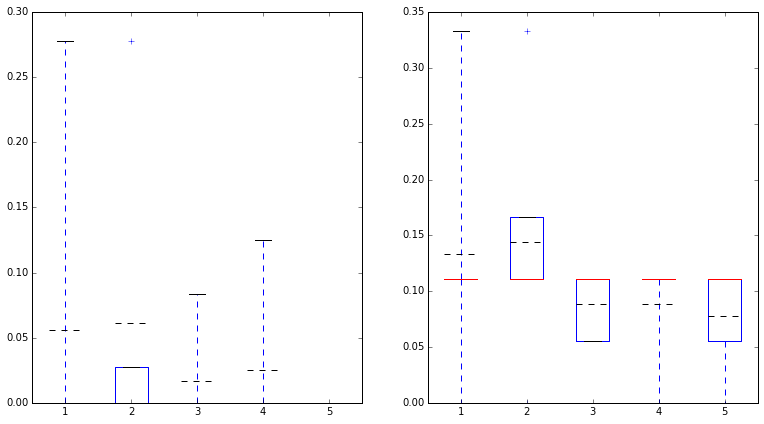

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 39
Beta: [ 3784.68752008    23.4030921   -114.80995477    -6.14759277  1206.91092477
 -2909.74807093   -38.84766298]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.4


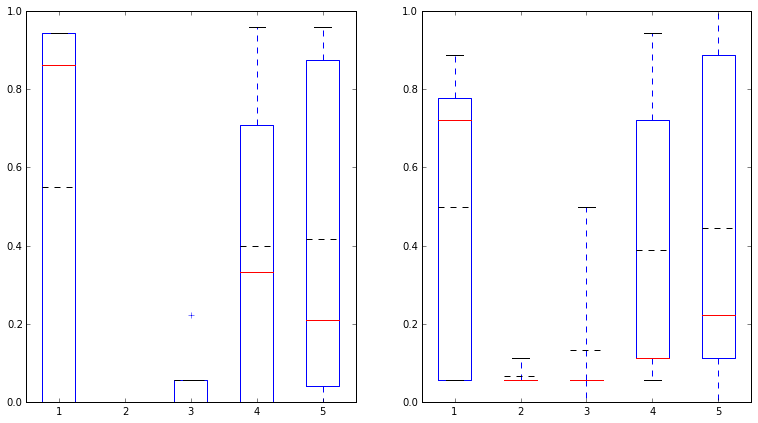

Training error rate: 0.1
Testing error rate: 0.0666666666667
N° iterations: 112
Beta: [  2.61681683e+29   2.10106676e+26  -7.51994631e+27  -3.23929918e+26
   1.06390761e+29  -2.93329651e+29  -6.11372100e+26]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.2


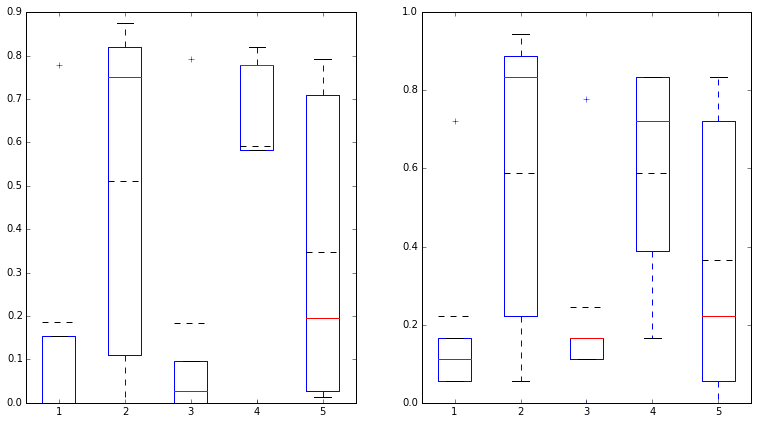

Training error rate: 0.766666666667
Testing error rate: 0.8
N° iterations: 195
Beta: [  1.09611017e+16   5.32011432e+13  -3.69779995e+14  -1.54337788e+13
  -1.55003798e+26   4.65011394e+26  -2.68071406e+13]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.2


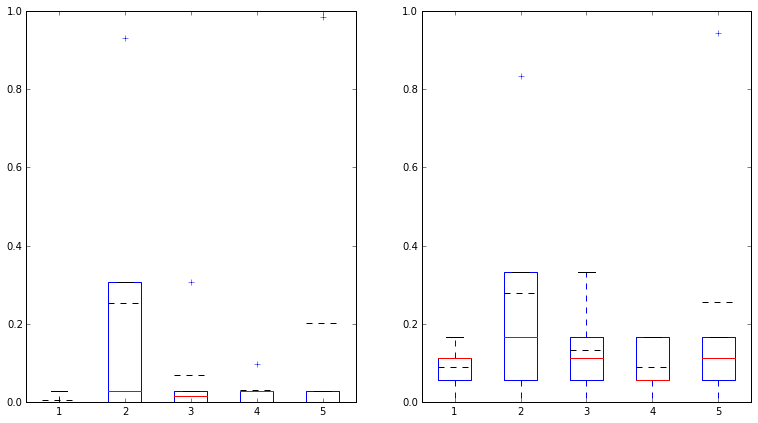

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 70
Beta: [ 333.06507736    1.73088216  -11.23027705   -0.46771727  117.81359724
 -297.75309867   -0.74126288]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.8


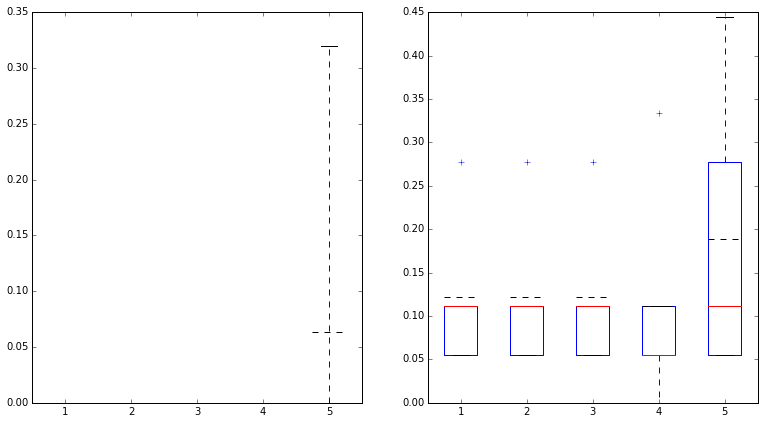

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 71
Beta: [ 1538.27502296    11.17368709   -43.08417409    -2.98792752   441.14943395
  -975.51811748   -23.01206682]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.4


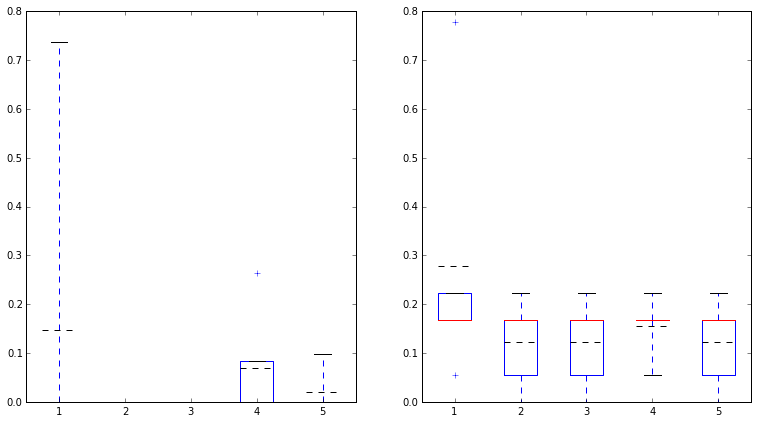

Training error rate: 0.744444444444
Testing error rate: 0.6
N° iterations: 100
Beta: [  8.03166122e+41  -1.02370143e+28   4.86853649e+28   2.55744628e+27
  -4.62326564e+29  -8.03166122e+41   1.51853978e+28]
###########################################################


###########################################################
Dataset: 18
Best alpha: 1.0


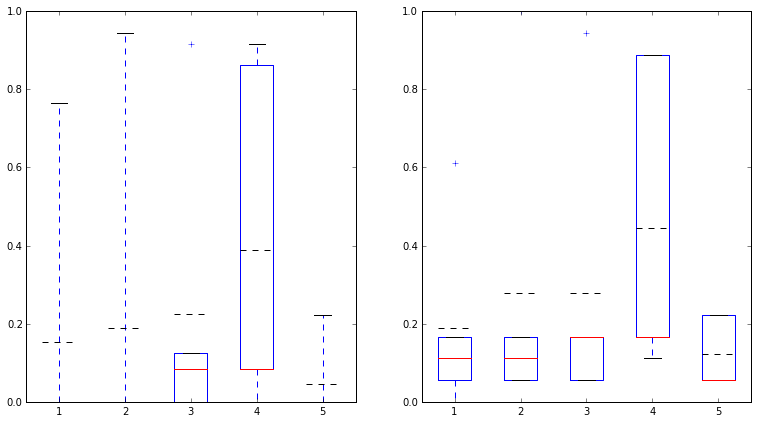

Training error rate: 0.0888888888889
Testing error rate: 0.1
N° iterations: 45
Beta: [  6.60456620e+03   4.73341662e+01  -2.14747446e+02  -9.20807212e+00
   1.54926683e+12  -4.64780048e+12  -7.83973281e+01]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.6


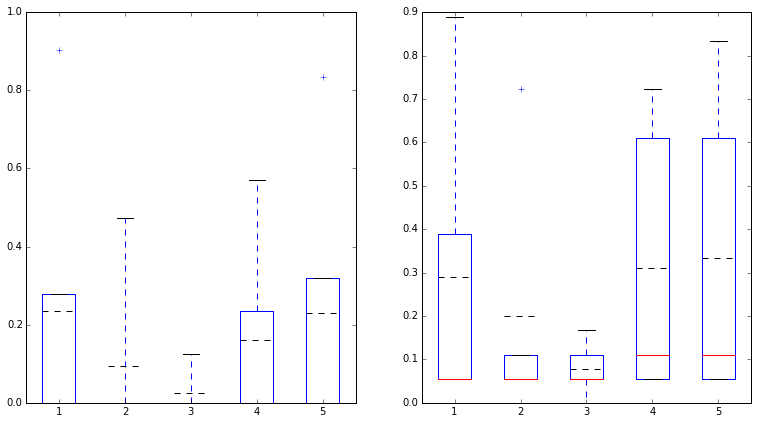

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 69
Beta: [  2.42257501e+03   2.31831789e+00  -7.90755632e+01  -3.33503054e+00
   6.69074361e+02  -1.60816179e+03   4.77392216e+00]
###########################################################




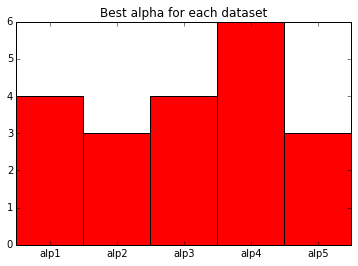

In [25]:
solve_logistic(nr_logistic, params1)

###########################################################
Dataset: 0
Best alpha: 0.2


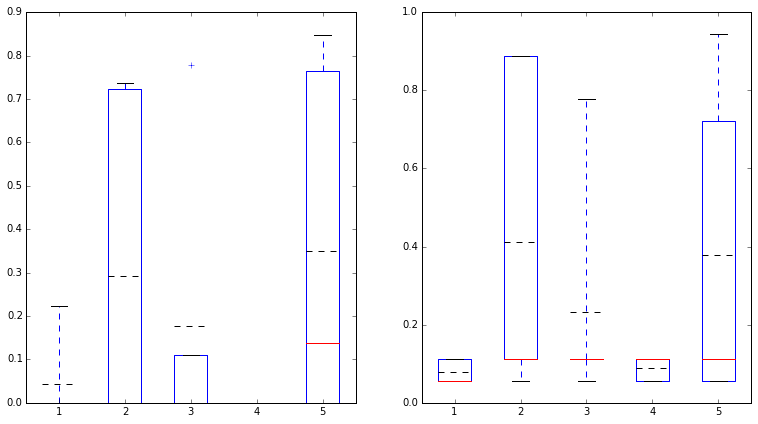

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 306
Beta: [  403.17533722   820.96644589 -4042.53731287  -909.2673169   9013.72824914
 -2890.82982924   119.23537701]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.2


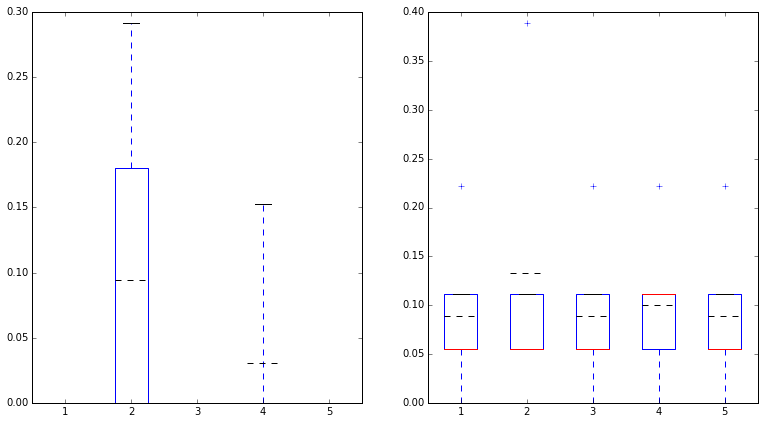

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 324
Beta: [ 1368.12235724  -493.17224455 -4650.84991261  -937.58950021  9608.21424165
 -2963.62442416   174.00060381]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.2


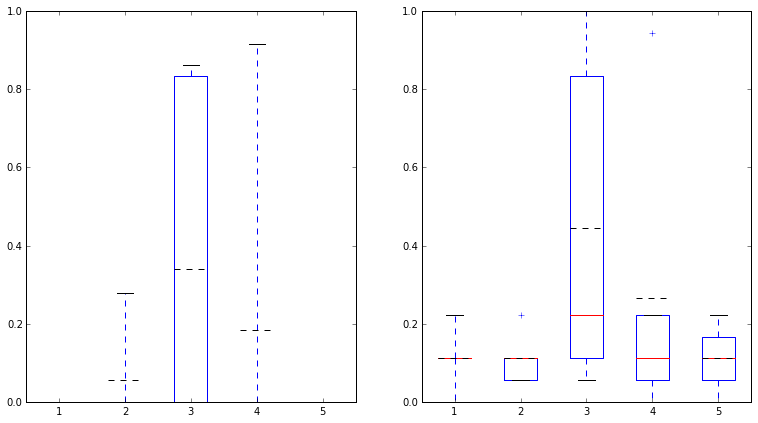

Training error rate: 0.0
Testing error rate: 0.2
N° iterations: 225
Beta: [  511.30766707  -132.13826935 -1115.7161734   -385.5482107   2079.42654945
  -859.68271936  -213.19909913]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.4


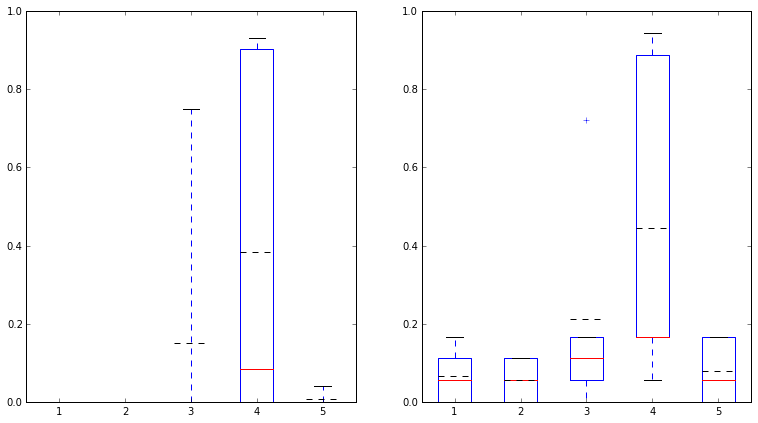

Training error rate: 0.1
Testing error rate: 0.166666666667
N° iterations: 105
Beta: [ -1.57035286e+29   3.96672376e+31  -9.27562194e+31  -2.37402222e+31
   2.48967772e+46  -9.33629145e+45  -8.11296384e+30]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.6


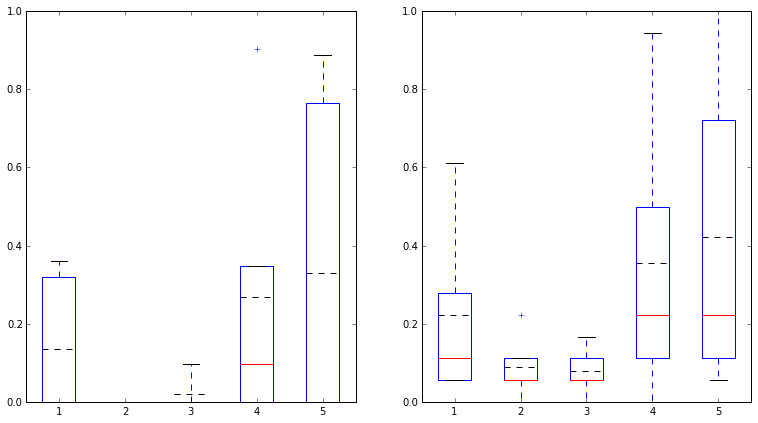

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 74
Beta: [   874.28761684    955.1803553   -4678.56727714  -1352.57682369
  10278.28262432  -3112.85045345   -952.99561226]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.4


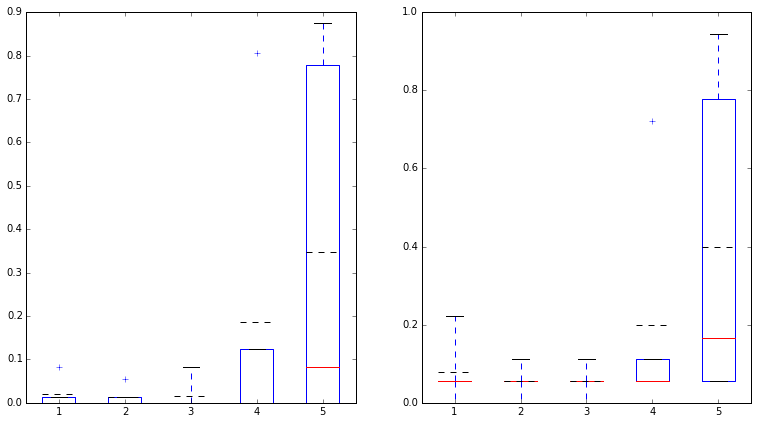

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 123
Beta: [  3121.32974545   1939.88387458 -16715.2552242   -3650.177319
  33635.54620703 -10646.86146648   -515.69312123]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.4


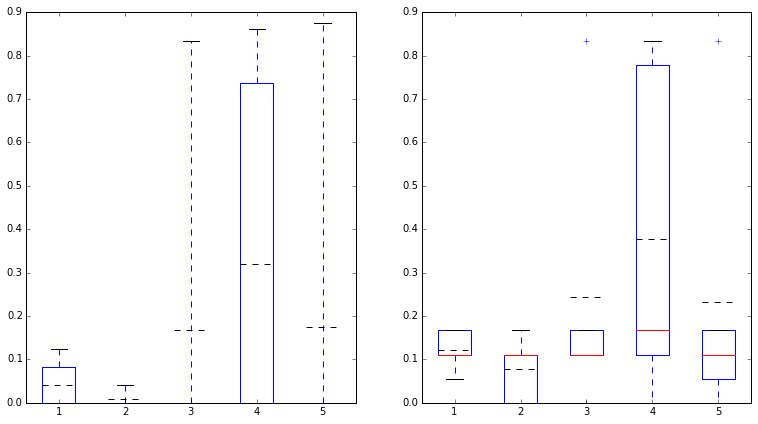

Training error rate: 0.422222222222
Testing error rate: 0.433333333333
N° iterations: 104
Beta: [ -2.77145831e+40  -1.30191434e+40   1.26358761e+41   3.00151296e+40
   3.71592495e+40  -3.09289170e+40  -4.15087276e+38]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.6


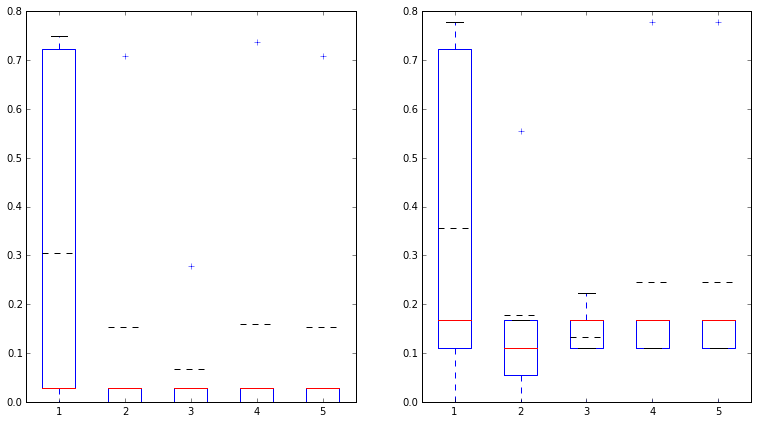

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 24
Beta: [  23.05059358   33.0689502  -189.61661265  -40.53395643  439.42826807
 -139.8762308    -1.39994843]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.2


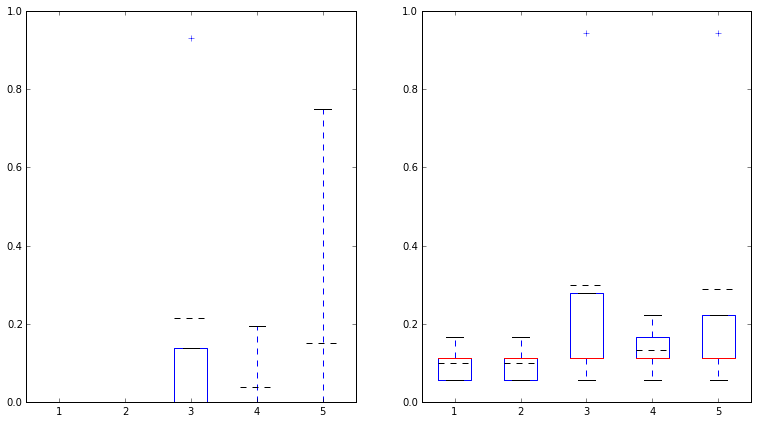

Training error rate: 0.944444444444
Testing error rate: 0.933333333333
N° iterations: 202
Beta: [ -8.13734170e+15  -9.68815889e+14   3.98262971e+16   8.76511885e+15
  -5.09709947e+16   1.65705267e+16  -1.91214795e+15]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.6


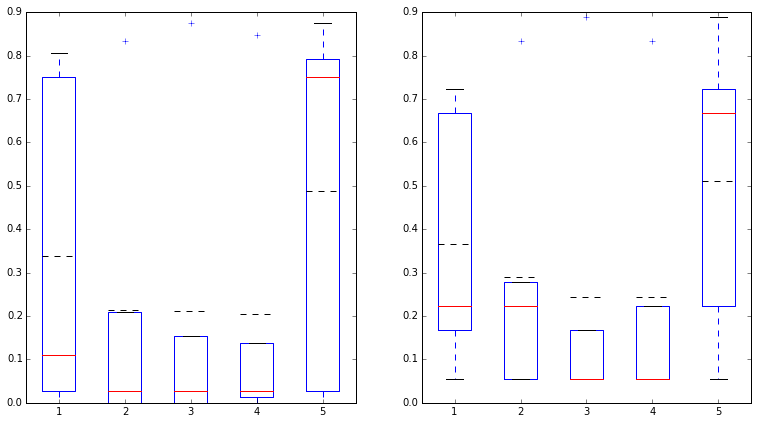

Training error rate: 0.133333333333
Testing error rate: 0.333333333333
N° iterations: 68
Beta: [ -2.75602802e+02   1.22294210e+04  -8.42815122e+04  -1.91697583e+04
   5.51240451e+17  -2.06715169e+17  -4.51391668e+03]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.6


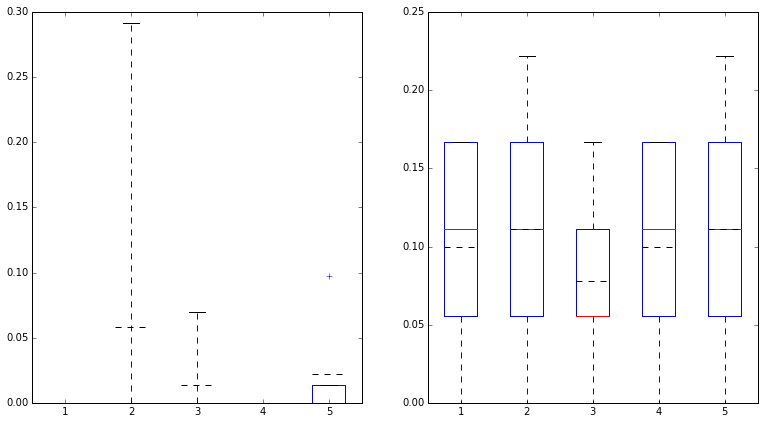

Training error rate: 0.733333333333
Testing error rate: 0.9
N° iterations: 70
Beta: [  5.31213725e+02   4.26657108e+02  -2.69686307e+03  -7.25991907e+02
  -3.41567293e+14   1.46385983e+14  -4.62262281e+02]
###########################################################


###########################################################
Dataset: 11
Best alpha: 1.0


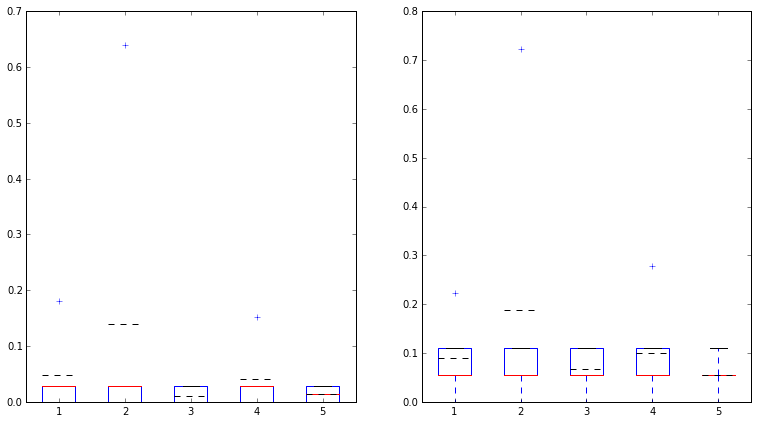

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 16
Beta: [  72.54940286   64.84160581 -440.58204416  -98.54777607  957.10260405
 -306.68916908  -16.21455461]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.6


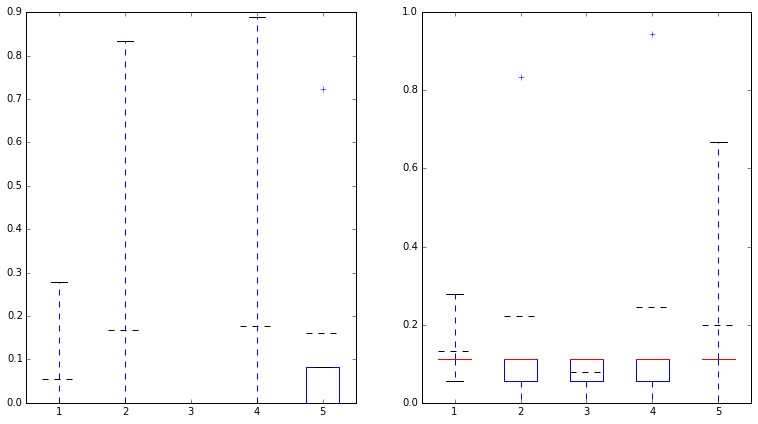

Training error rate: 0.277777777778
Testing error rate: 0.3
N° iterations: 66
Beta: [ -3.60594331e+13   9.00860463e+02  -4.63084087e+03  -1.33266379e+03
   9.99510622e+03   3.60594331e+13  -8.75620746e+02]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.8


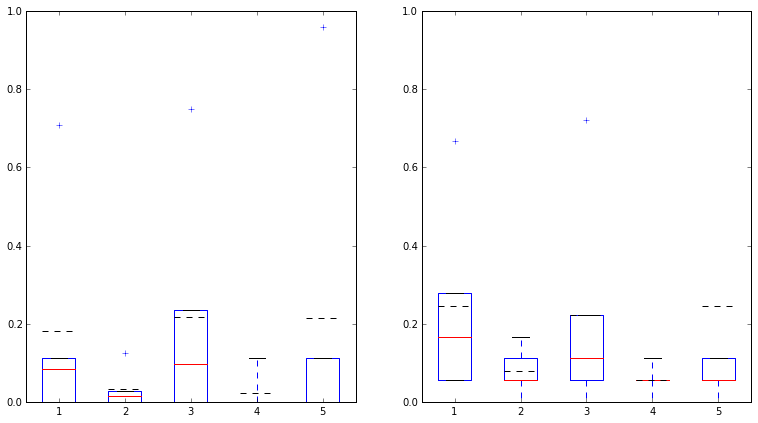

Training error rate: 0.144444444444
Testing error rate: 0.1
N° iterations: 17
Beta: [ -4.62919722e+18   4.98020047e+18  -1.56719220e+19  -3.52957874e+18
   4.12375442e+19  -8.15442266e+18  -8.71048641e+17]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.8


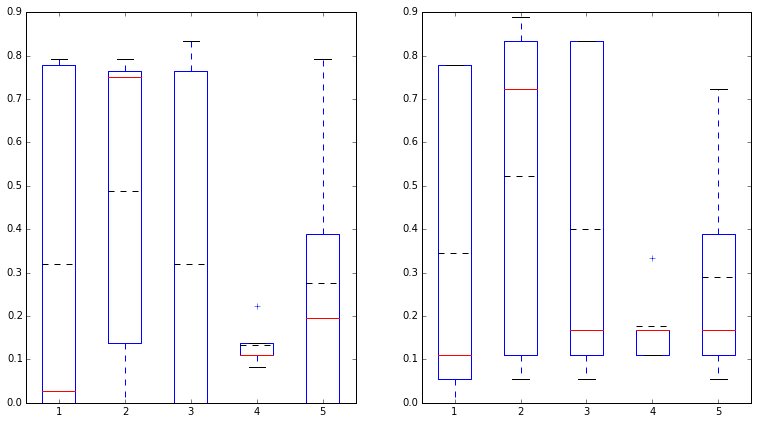

Training error rate: 0.788888888889
Testing error rate: 0.566666666667
N° iterations: 57
Beta: [  1.96382055e+05   1.18958614e+05  -8.89383825e+05  -1.99386501e+05
  -2.43394616e+17   9.12729809e+16  -3.77438072e+04]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.2


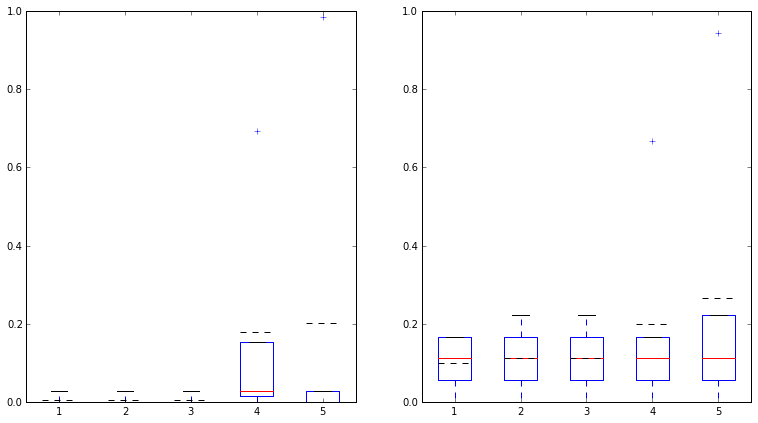

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 70
Beta: [  68.02194047   64.34511143 -425.57134887  -97.73027239  942.50877792
 -297.75309867  -14.36196829]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.4


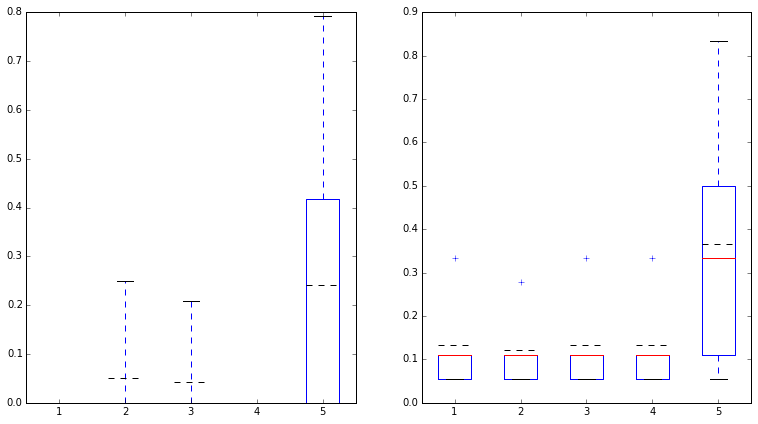

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 123
Beta: [  328.02015068   371.15795255 -1533.66017163  -578.03959615  3255.8185186
  -897.39047035  -489.44739504]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.8


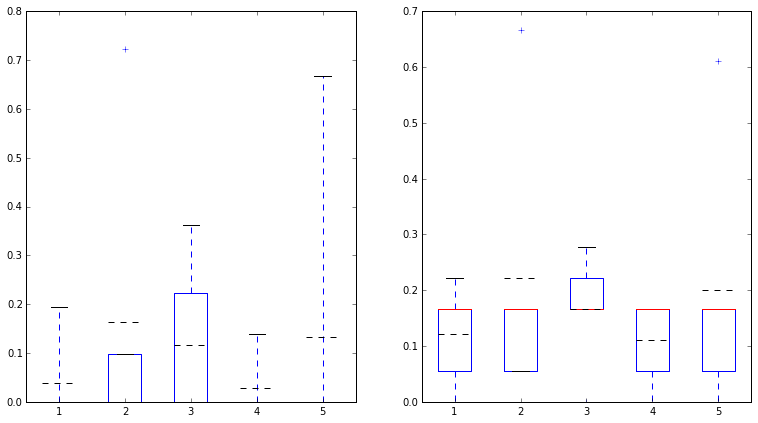

Training error rate: 0.911111111111
Testing error rate: 0.733333333333
N° iterations: 52
Beta: [ -2.37438205e+41  -9.05630048e+28   4.51261867e+29   1.36691938e+29
  -8.80933445e+29   2.37438205e+41   9.21927709e+28]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.2


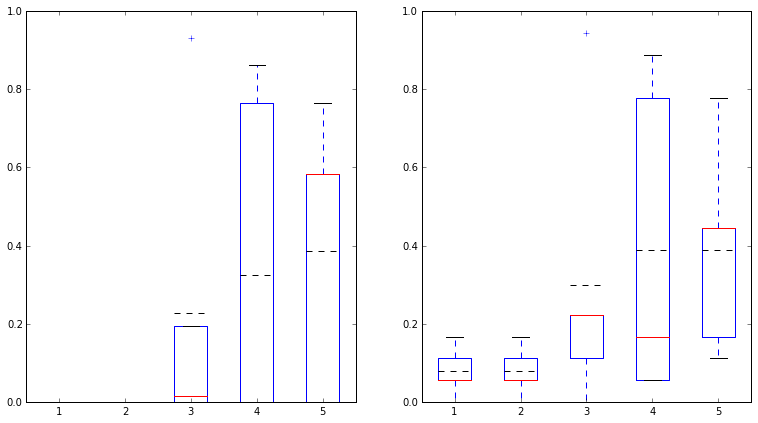

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 224
Beta: [   554.59164122    874.96986471  -4353.20082791  -1022.94638004
  10565.64911993  -3271.59931233   -989.9647166 ]
###########################################################


###########################################################
Dataset: 19
Best alpha: 1.0


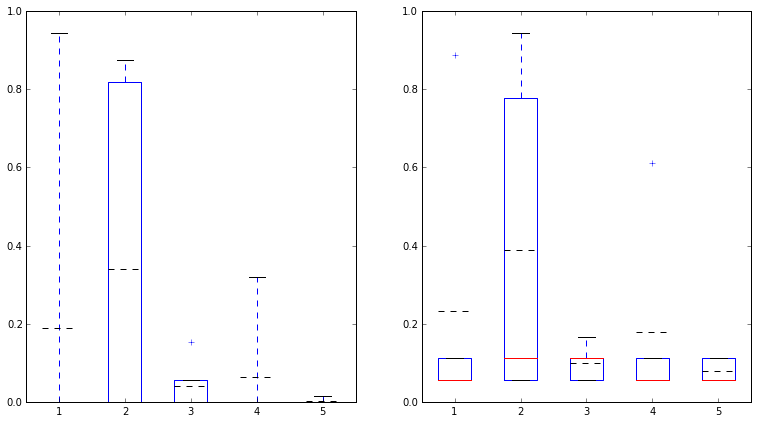

Training error rate: 0.855555555556
Testing error rate: 0.766666666667
N° iterations: 43
Beta: [ -1.43882276e+19   2.27702581e+19  -1.80704305e+18   3.11197634e+17
  -2.53530120e+30   1.08655766e+30  -4.44988616e+17]
###########################################################




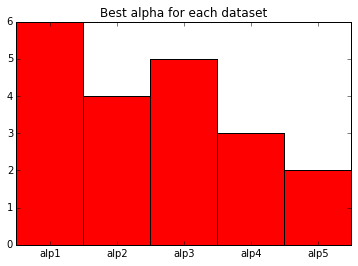

In [26]:
solve_logistic(nr_logistic, params1, rescale)

###########################################################
Dataset: 0
Best alpha: 0.2


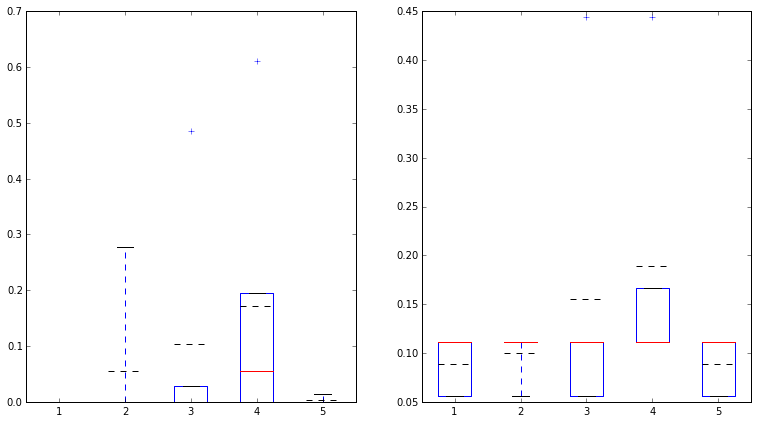

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 260
Beta: [  -60.14111749   210.91643787  -995.83336414  -323.98326533  1944.18606247
 -1254.46881236    25.67057134]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.2


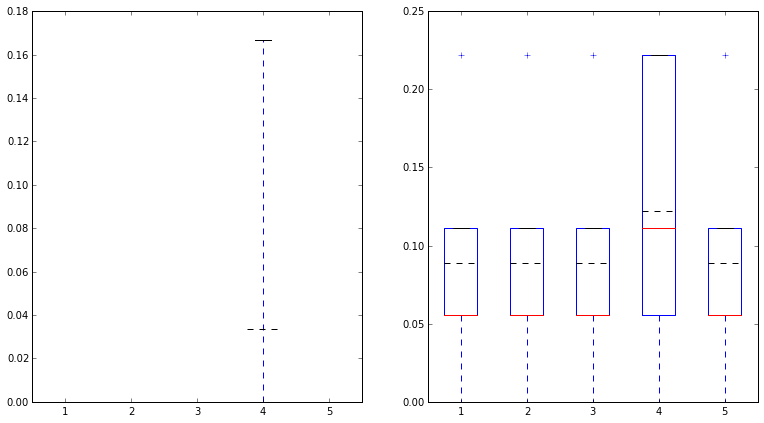

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 285
Beta: [  -42.80901837  -129.95201628 -1205.71573278  -349.37134083  2074.0937013
 -1337.16263784    34.93461495]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.6


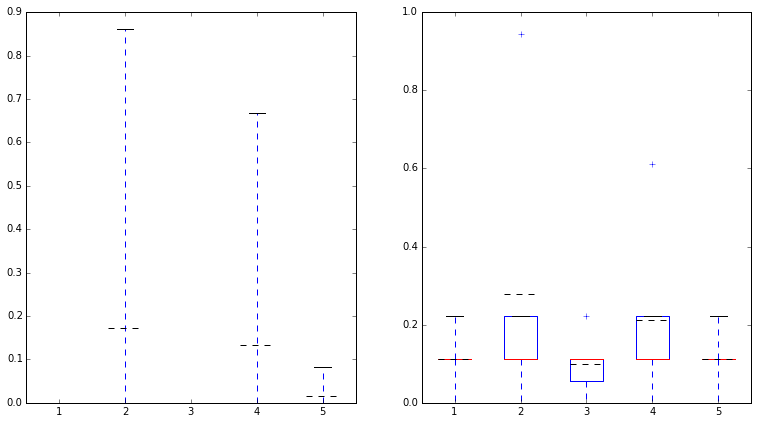

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 94
Beta: [ -42.6398427   -42.84129428 -342.14543184 -168.71918884  625.34724423
 -481.48139903  -50.25590159]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.6


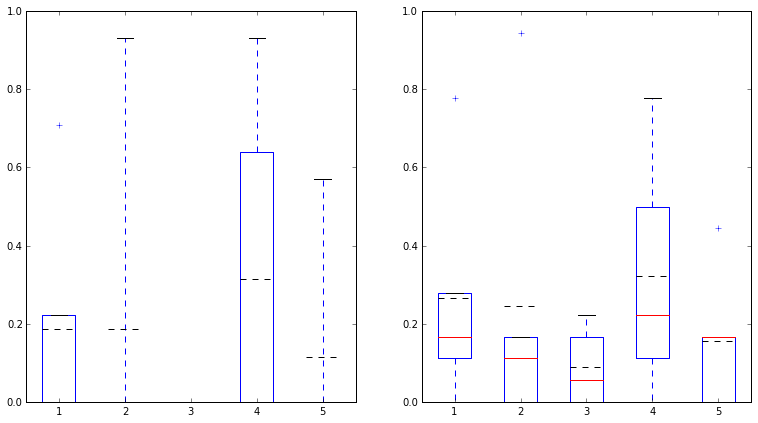

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 124
Beta: [   4.36463668   65.10222628 -517.91559563 -114.38409119  998.56879844
 -589.54871087   35.28941142]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.2


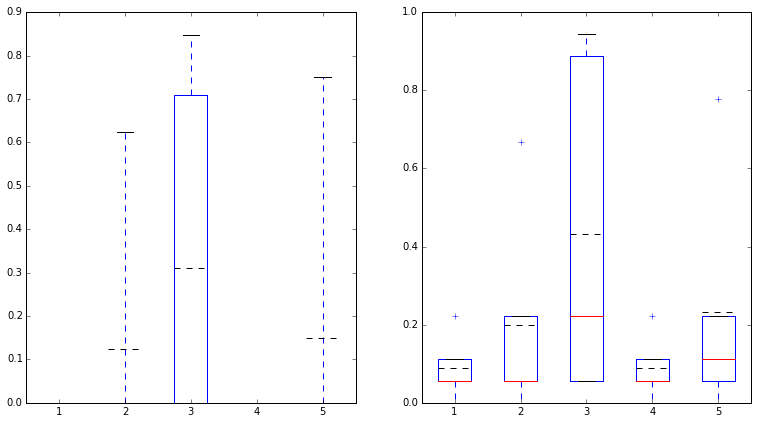

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 234
Beta: [ -433.52931172   271.9301953  -1291.1347422   -570.52546171  2568.90930335
 -1469.17296951  -219.05165906]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.6


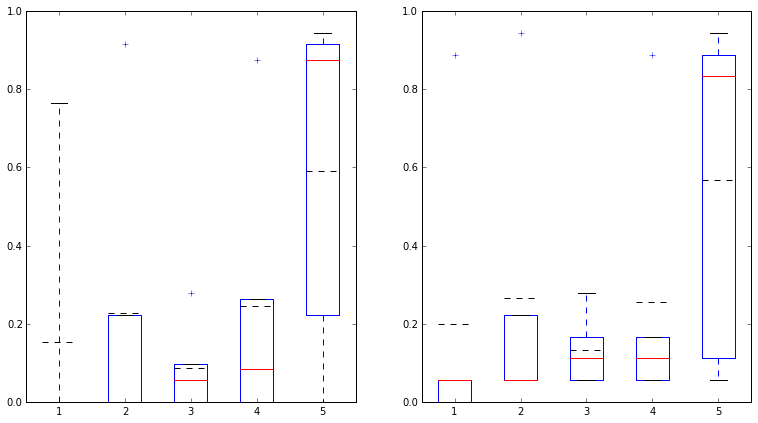

Training error rate: 0.0777777777778
Testing error rate: 0.133333333333
N° iterations: 72
Beta: [  2.51848847e+29   1.03203056e+17  -8.57785898e+17  -2.98654118e+17
   1.05222271e+30  -8.19210724e+29  -2.24860225e+16]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.6


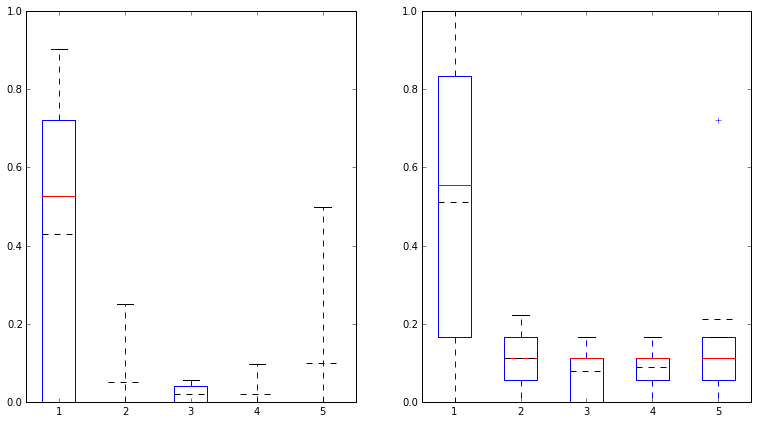

Training error rate: 0.388888888889
Testing error rate: 0.5
N° iterations: 101
Beta: [  1.74672409e+26   1.18026073e+26  -3.47775473e+26   8.36594763e+25
   2.90131401e+26  -2.79082871e+26  -6.27877655e+26]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.2


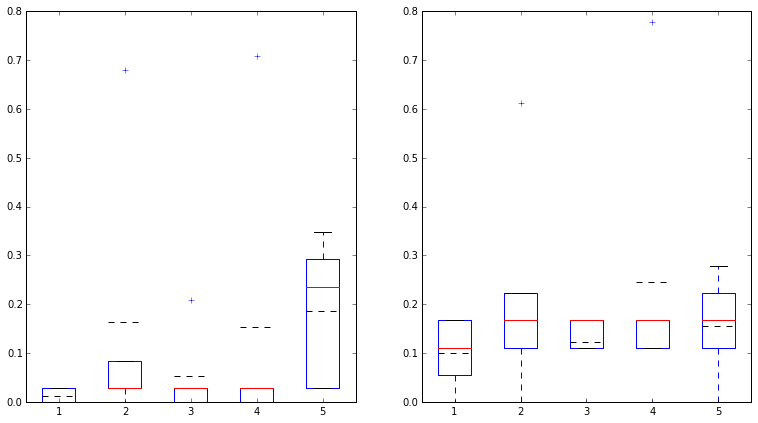

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 67
Beta: [  -6.74149961    9.27585304  -52.71052459  -16.58532723  102.25711105
  -66.92244913   -0.30369144]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.2


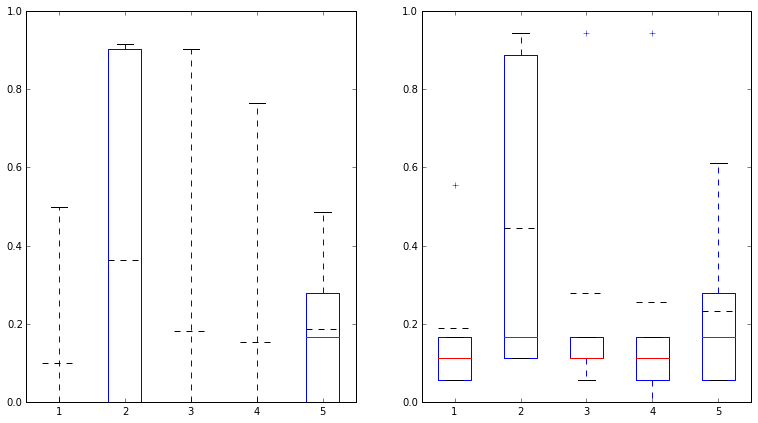

Training error rate: 0.0666666666667
Testing error rate: 0.0666666666667
N° iterations: 223
Beta: [ -1.51380877e+26  -1.52089068e+27  -8.57565589e+27  -2.99475370e+27
   1.00417080e+28  -6.08338731e+27   1.64718150e+26]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.4


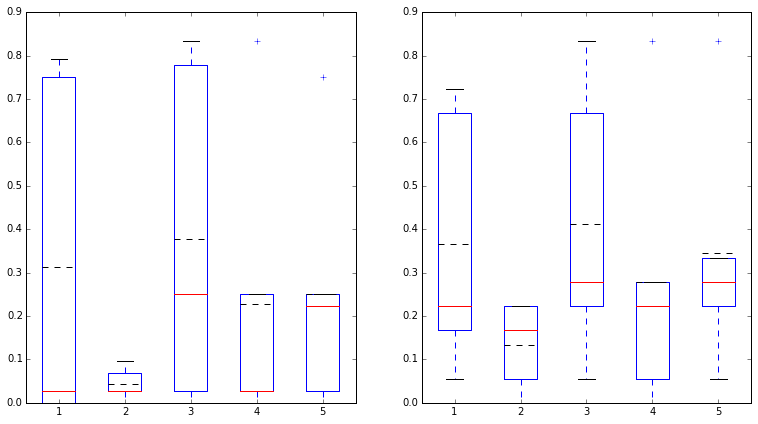

Training error rate: 0.844444444444
Testing error rate: 0.866666666667
N° iterations: 110
Beta: [ -1.29477667e+21   6.69349076e+20   5.00600126e+19   7.45498629e+19
  -4.78835096e+21   2.79715029e+21   2.57512494e+19]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.2


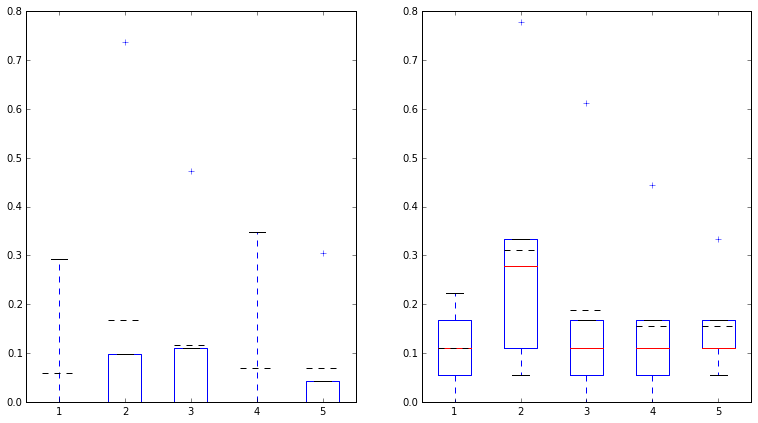

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 346
Beta: [ -137.62166984   171.14019211 -1074.43374367  -446.00940624  1928.00248824
 -1180.98206299  -138.83050789]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.6


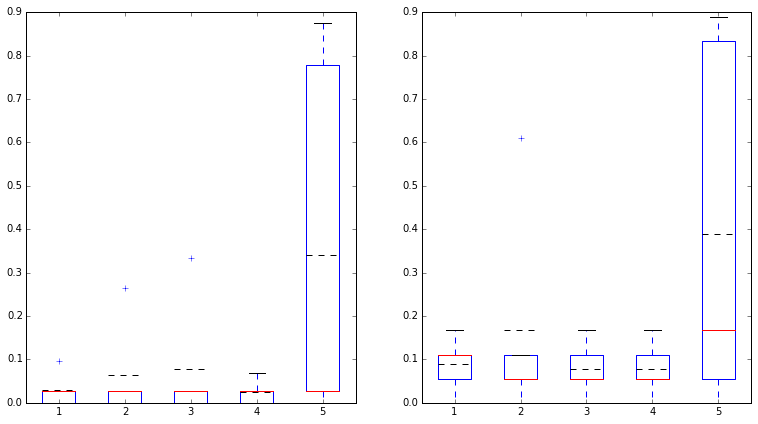

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 25
Beta: [ -25.09230904   18.46002464 -121.48761209  -38.64568691  205.13426166
 -147.95097367   -3.73099628]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.2


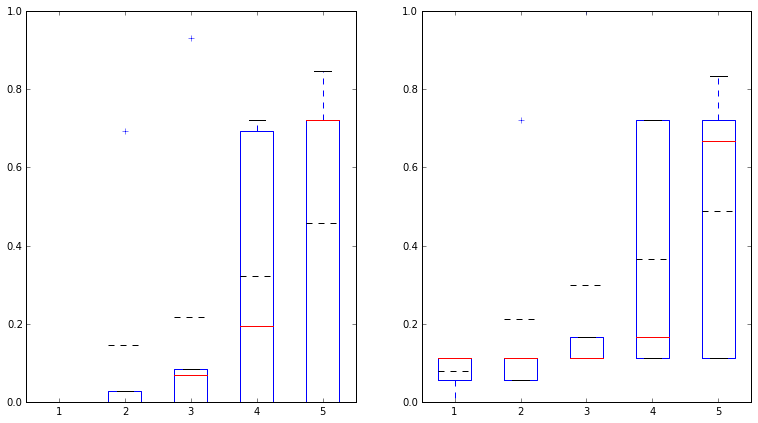

Training error rate: 0.922222222222
Testing error rate: 0.733333333333
N° iterations: 197
Beta: [ -2.43120385e+42  -2.45921814e+29   1.27409267e+30   5.64538432e+29
  -2.42039603e+30   3.27310835e+42   2.06891725e+29]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.2


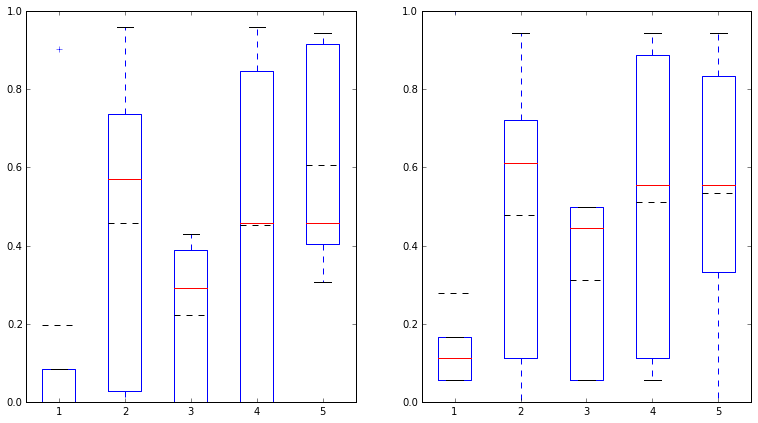

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 209
Beta: [ -865.77539564 -1525.89481516 -5925.05741319 -2155.1086108   6521.49412554
 -4052.32268649  -143.88882892]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.6


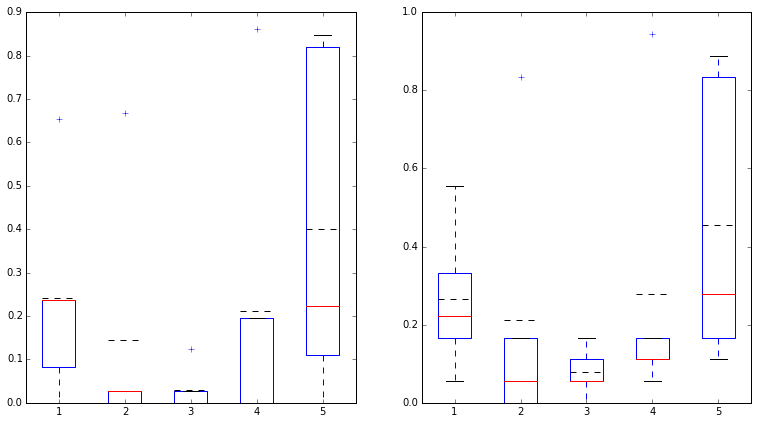

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 69
Beta: [  16.96227501   18.18216981 -124.95847509  -40.73476592  262.3598964
 -165.46726821   -3.77485352]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.6


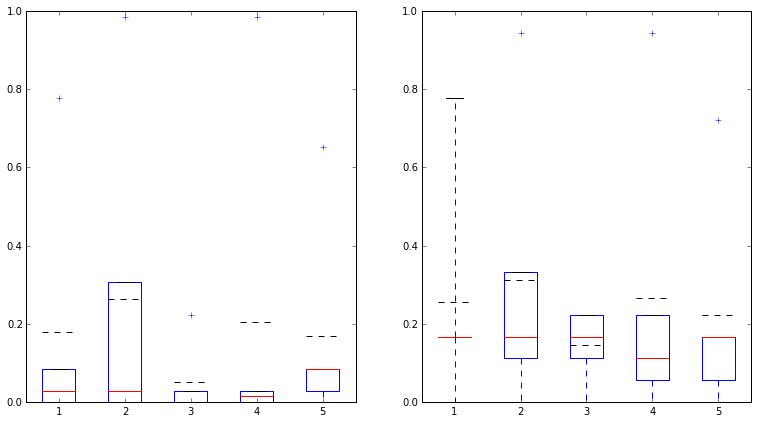

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 25
Beta: [  -1.74335987   17.84144914 -118.43731658  -41.10808597  218.58570218
 -148.04563625   -3.49285296]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.2


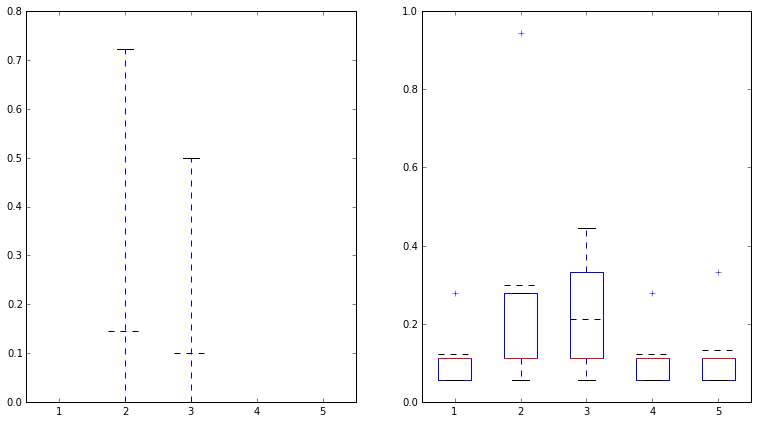

Training error rate: 0.0
Testing error rate: 0.2
N° iterations: 218
Beta: [   8.65008245   92.12626372 -373.64109105 -221.1702541   750.04693164
 -396.01611494 -102.25811851]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.2


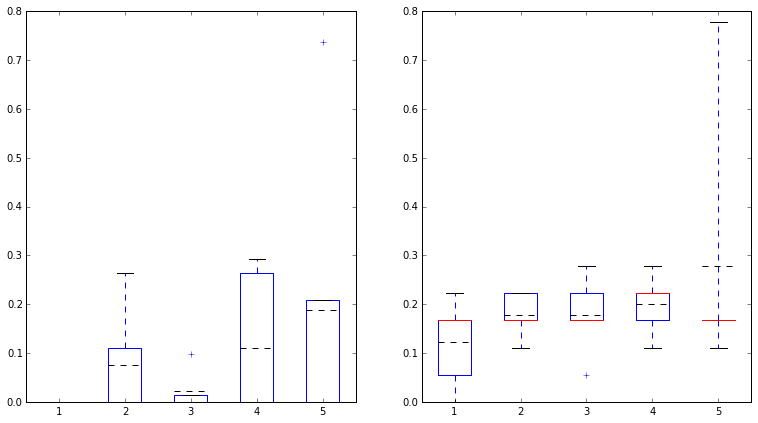

Training error rate: 0.911111111111
Testing error rate: 0.733333333333
N° iterations: 199
Beta: [ -5.56370127e+42  -1.32346168e+29   6.59239789e+29   3.00352842e+29
  -1.14582378e+30   7.67554040e+42   1.18563962e+29]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.2


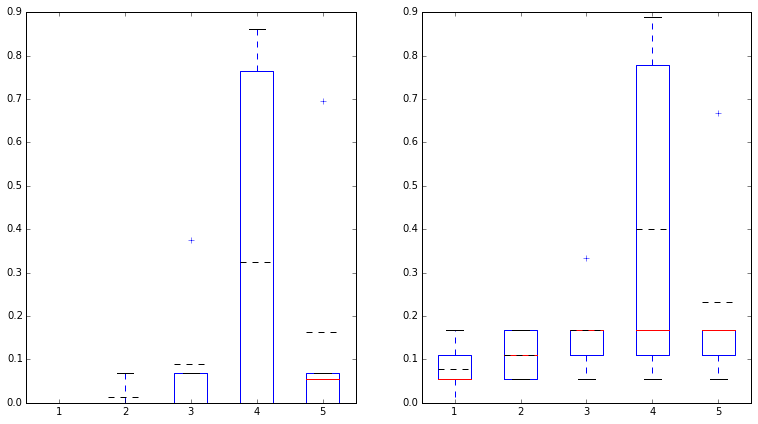

Training error rate: 0.777777777778
Testing error rate: 0.8
N° iterations: 205
Beta: [ -5.79597525e+43   3.31140992e+30  -1.71173985e+31  -6.11268280e+30
  -1.36031432e+44   1.03601057e+44  -2.84108169e+30]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.6


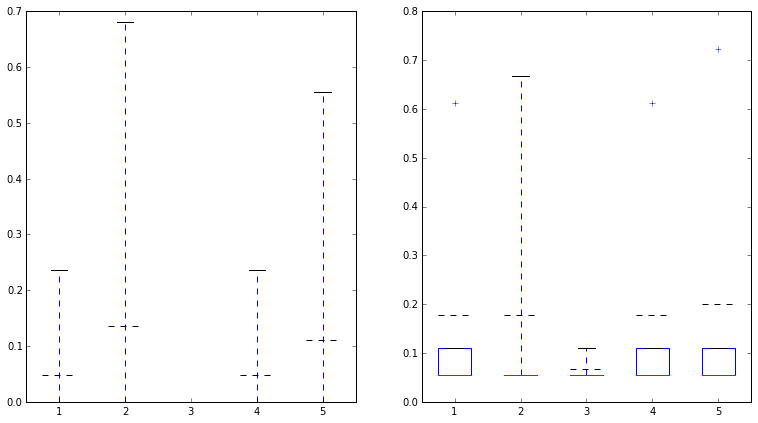

Training error rate: 0.766666666667
Testing error rate: 0.7
N° iterations: 71
Beta: [  3.61265136e+17   1.73692100e+14   6.86958778e+17   2.52165849e+17
  -1.60878823e+17  -4.84950962e+16  -1.03967275e+16]
###########################################################




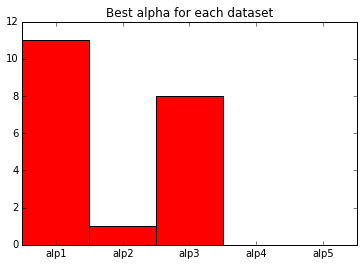

In [27]:
solve_logistic(nr_logistic, params1, normalize)

In [ ]:
solve_logistic(gd_stochastic, params2)

In [ ]:
solve_logistic(gd_stochastic, params2, rescale)

In [ ]:
solve_logistic(gd_stochastic, params2, normalize)